In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd

import sys
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
print("Adding to sys.path:", src_path)
sys.path.append(src_path)

print("Current sys.path:", sys.path)
from saffine import multi_detrending as md
from saffine import detrending_method as dm

Adding to sys.path: /Users/au324704/Desktop/fanfic_sentiment/src
Current sys.path: ['/Users/au324704/.pyenv/versions/3.11.1/lib/python311.zip', '/Users/au324704/.pyenv/versions/3.11.1/lib/python3.11', '/Users/au324704/.pyenv/versions/3.11.1/lib/python3.11/lib-dynload', '', '/Users/au324704/.pyenv/versions/3.11.1/lib/python3.11/site-packages', '/Users/au324704/aclpubcheck', '/Users/au324704/Desktop/fanfic_sentiment/src']


In [3]:


def integrate(x):
    return np.mat(np.cumsum(x) - np.mean(x))

def normalize(ts, scl01 = False):
    ts01 = (ts - np.min(ts)) / (np.max(ts) - np.min(ts))
    ts11 = 2 * ts01 -1
    if scl01:
        return ts01
    else:
        return ts11

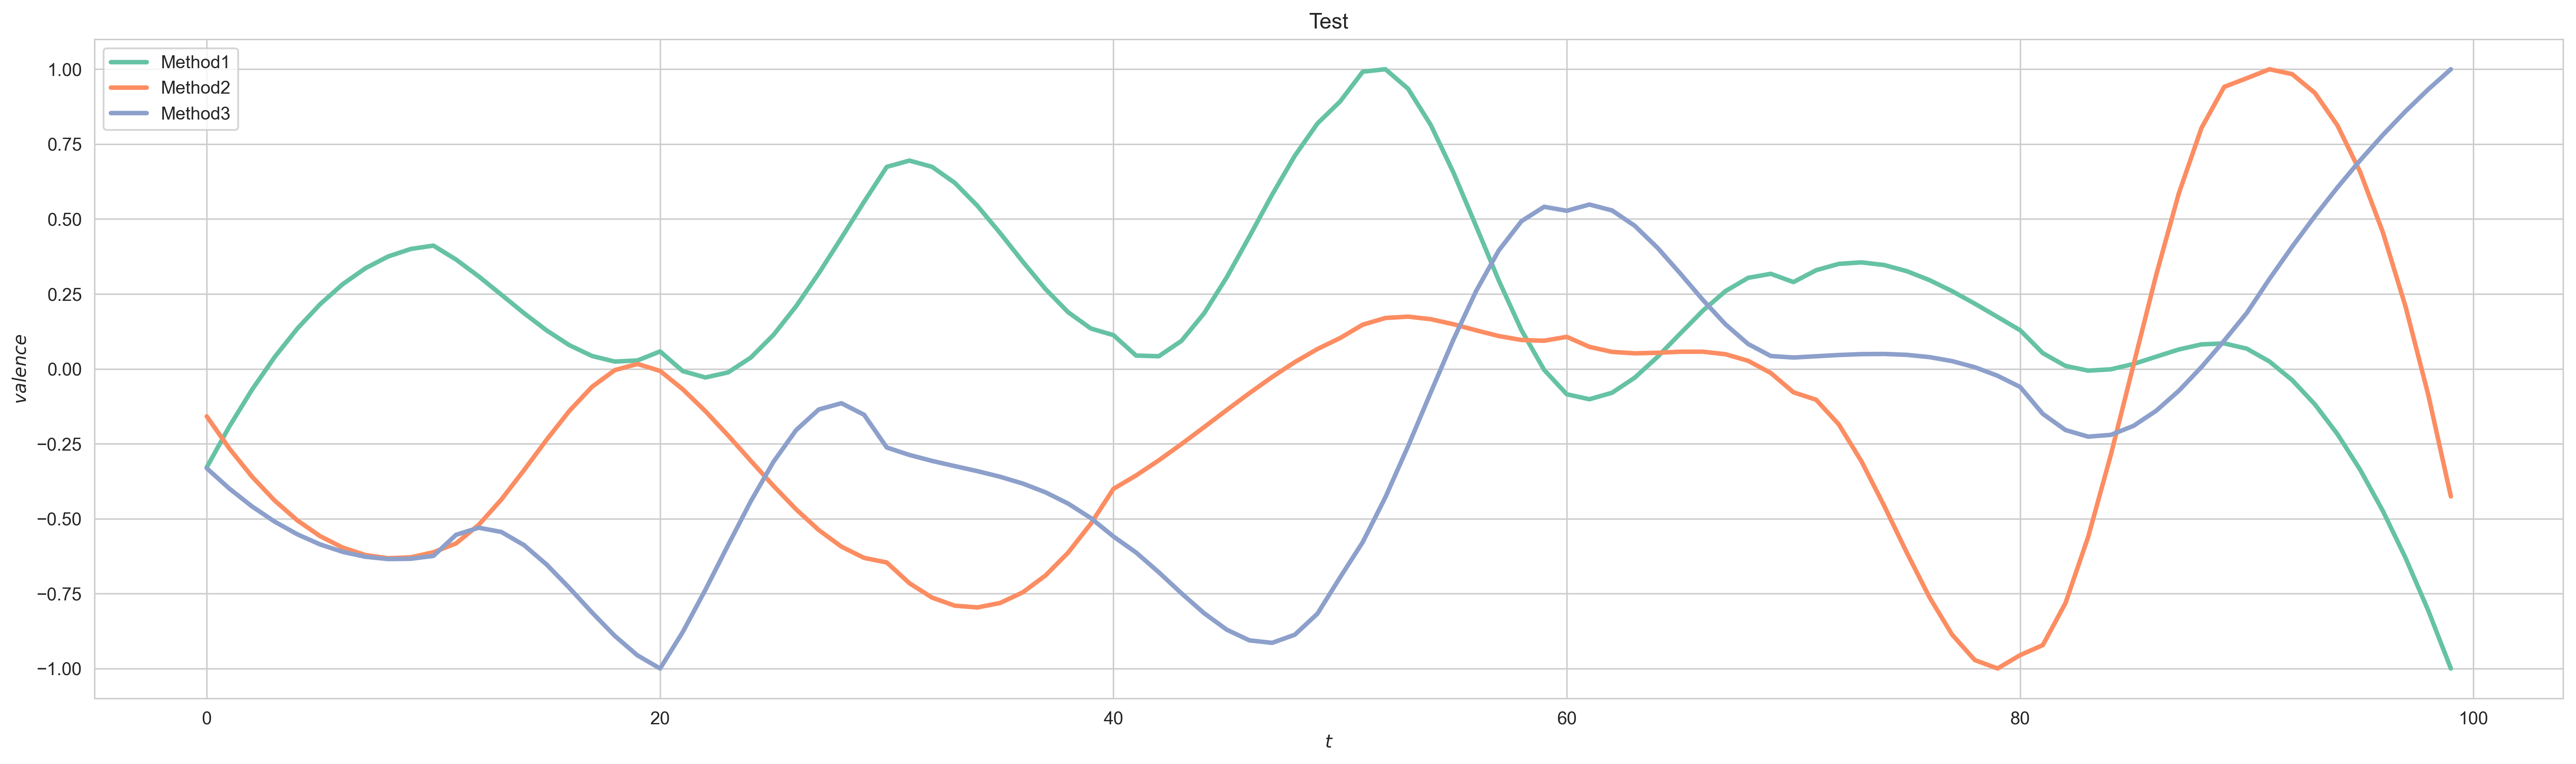

Hurst value: 0.45


In [12]:
def figure(sentiment_arcs, method, plottitle, l=12, h=20):

    plt.figure(figsize=(l, h), dpi=300)
    
    # Getting colors
    colors = sns.color_palette("Set2", len(sentiment_arcs))

    for j, story_arc in enumerate(sentiment_arcs):

        y = integrate(story_arc)
        uneven = y.shape[1] % 2
        if uneven:
            y = y[0, :-1]

        # afa
        # n = 500
        step_size = 1
        q = 3
        order = 1
        xy = md.multi_detrending(y, step_size, q, order)
        
        ## slope
        x = np.squeeze(np.asarray(xy[0]))
        y = np.squeeze(np.asarray(xy[1]))

        # p = np.poly1d(np.polyfit(x, y, order))
        # xp = np.linspace(0, len(x), len(x))

        sns.set_style("whitegrid")
        
        X = np.mat([float(x) for x in story_arc])
        #plt.plot(X.T, color="grey", linestyle='-', alpha=0.5, label=method[j]) # Uncomment to see the raw arc; changed to grey
        n = len(story_arc)
        w = int(4 * np.floor(n / 20) + 1)

        # format
        if method[j] == 'Human' or method[j] == 'mean':
            for i in range(2, 3):
                try:
                    _, trend_ww_1 = dm.detrending_method(X, w, i)
                    plt.plot(normalize(trend_ww_1).T, label=str(method[j]), linewidth=2.5, color='k', linestyle='dashed')
                except:
                    print("error")
                    X = np.mat([float(x) for x in story_arc + [0]])
                    plt.plot(X.T, color='grey', label='story arc')
                    n = len(story_arc)
                    w = int(4 * np.floor(n / 20) + 1)
        else:
            for i in range(2, 3):
                try:
                    _, trend_ww_1 = dm.detrending_method(X, w, i)
                    plt.plot(normalize(trend_ww_1).T, label=str(method[j]), linewidth=2.5, color=colors[j])
                except:
                    print("error")
                    X = np.mat([float(x) for x in story_arc + [0]])
                    plt.plot(X.T, color='grey', label='story arc')
                    n = len(story_arc)
                    w = int(4 * np.floor(n / 20) + 1)
                    pass

    plt.title(plottitle)
    plt.legend()
    plt.xlabel('$t$')
    plt.ylabel('$valence$')

    plt.tight_layout()
    plt.show()  # Show the figure after all arcs are plotted

    H = round(np.polyfit(x, y, 1)[0], 2)
    return H


# test the figure function with dummy data
dummy = np.random.rand(3, 100)  # 3 arcs, each 100 time points
dummy_methods = ['Method1', 'Method2', 'Method3']  # 3 method labels
dummy_title = 'Test'
hurst_value = figure(dummy, dummy_methods, dummy_title, l=20, h=6)
print(f"Hurst value: {hurst_value}")


In [ ]:
# load fanfic arcs
# these are too big for the repo
df = pd.read_csv('data/all_fics_w_sentiment.csv')
df = df[['text_id', 'xlm-roberta-base-sentiment-multilingual', 'syuzhet', 'subset', 'fandom_label']]
cats = ['fluff', 'angst', 'hurt/comfort']
# Filter the DataFrame for the specified categories
df = df[df['subset'].isin(cats)]
df.head()

,text_id,xlm-roberta-base-sentiment-multilingual,syuzhet,subset,fandom_label
3,9kfics_4869863,"[-0.8281025290489197, -0.9183330535888672, 0.3...","[-0.75, -0.65, 0.0, 0.0, -0.75, 1.35, -0.25, -...",fluff,PJ
4,9kfics_47250961,"[0.7041895389556885, -0.7854205965995789, -0.8...","[0.0, -0.09999999999999998, -0.050000000000000...",fluff,PJ
6,9kfics_31477622,"[0.0, 0.0, 0.0, 0.0, -0.4796947240829468, 0.0,...","[-0.25, 0.8, 0.0, 0.8, 0.0, 0.0, -0.25, -1.0, ...",fluff,PJ
8,9kfics_5550113,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.445...","[0.0, -1.0, -0.5, -0.5, 0.0, 0.0, 0.0, 0.0, 0....",fluff,PJ
10,9kfics_38992872,"[0.0, 0.0, 0.555084228515625, -0.5139297246932...","[0.0, 0.0, -0.25, 0.1499999999999999, 0.75, 1....",fluff,PJ


In [1]:
# add a arc_length column for syuzhet and roberta
df['arc_length_syuzhet'] = df['syuzhet'].apply(lambda x: len(eval(x)))
df['arc_length_roberta'] = df['xlm-roberta-base-sentiment-multilingual'].apply(lambda x: len(eval(x)))
df.head()

NameError: name 'df' is not defined

In [2]:
# see how many rows, based on syuzhet have arcs of the same length
measure = 'syuzhet'

# get arcs that have len = 56
same_length = df[df['arc_length_syuzhet'] == 56]
same_length.head()

NameError: name 'df' is not defined

In [3]:
# sample 3 random arcs from each category
sampled_arcs = []
fandoms = []
text_ids = []
subsets = []

for cat in cats:
    arcs = same_length[same_length['subset'] == cat]['xlm-roberta-base-sentiment-multilingual'].sample(1).tolist()
    fandom = same_length[same_length['subset'] == cat]['fandom_label'].sample(1).tolist()
    fandom = fandom[0] if isinstance(fandom, list) else fandom  # Ensure fandom is a string
    subset = same_length[same_length['subset'] == cat]['subset'].sample(1).tolist()   
    if fandom in fandoms:
        continue
    if subset in subsets:
        continue
    subsets.append(subset)
    fandoms.append(fandom)
    sampled_arcs.extend(arcs)
    text_ids.extend(same_length[same_length['subset'] == cat]['text_id'].sample(1).tolist())

print(f"Sampled fandoms: {fandoms}")
print(f"Sampled text IDs: {text_ids}")
print(f"Sampled arcs: {sampled_arcs}")
print(f"Sampled subsets: {subsets}")

# make sure sampled_arcs is a list of lists
sampled_arcs = [eval(arc) for arc in sampled_arcs]

NameError: name 'cats' is not defined

In [4]:
# test the figure function with dummy data
data = sampled_arcs  # 3 arcs, each 100 time points

# remove special characters from subsets
subsets = [str(subset).replace('\"', '').replace(']', '').replace('[', '').replace('\'','') for subset in subsets]
# combine fandom_label and subset into a single label
methods = [f"{fandom} - {subset}" for fandom, subset in zip(fandoms, subsets)]
# methods = ['Method1', 'Method2', 'Method3']
title = ''

hurst_value = figure(data, methods, title, l=12, h=4)
print(f"Hurst value: {hurst_value}")

NameError: name 'figure' is not defined